In [187]:
import sys
import time
import numpy as np
import numba as nb
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [188]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [189]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices, open_detector
from NumericalMethods.simpson_rule import simpson_rule
from NumericalMethods.unfolding_technique import Gold

import matplotlib.ticker as mticker
from local_scripts import initialization_brem, generate_empty_matrix, complete_empty_matrix, integrate_the_row, get_integral_signals, apply_function_to_matrix

In [190]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 16}
rc('font', **font_properties)

Инициализация энергетического спектра

In [191]:
beam_energy = 0.075
z_number = 50

In [192]:
brem = initialization_brem(z_number, beam_energy)

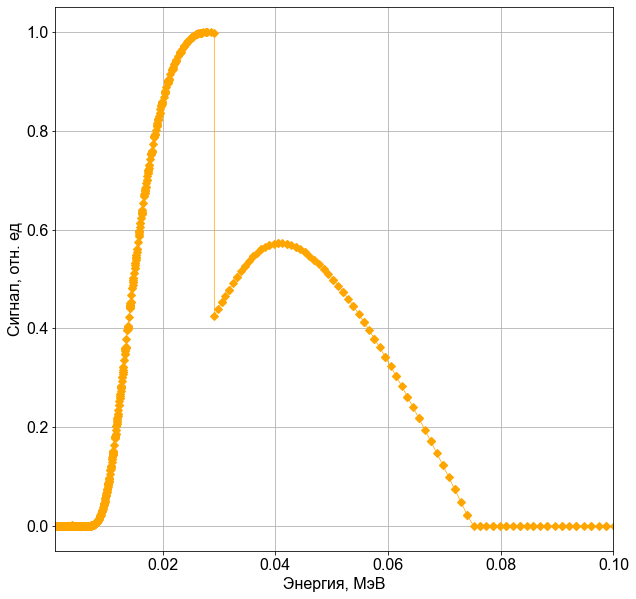

In [193]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Инициализация измерительных каналов

In [204]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel + 1

In [301]:
level = 0.3

In [302]:
system0 = np.array([ross_method_transmission_function(num, num+1, level, regime='different') for num in range(first_channel, last_channel)])
system1 = np.array([ross_method_transmission_function(num, num+1, level, regime='first') for num in range(first_channel, last_channel)])
system2 = np.array([ross_method_transmission_function(num, num+1, level, regime='second') for num in range(first_channel, last_channel)])
system3 = np.vstack((system1, system2))

Создание матрицы с измерительной системы

In [303]:
matrix0 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system0])
matrix1 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system1])
matrix2 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system2])

In [304]:
matrix3 = np.vstack((matrix1, matrix2))

In [305]:
matrix3.shape

(178, 1438)

In [306]:
new_mesh0 = np.array(simpson_rule(system1[0], regime='m', function_jumps=[Material(50).k_edge_index()]))
new_mesh1 = new_mesh0
new_mesh2 = new_mesh0
new_mesh3 = new_mesh0

Измерение энергетического спектра

In [307]:
signals0 = np.array([simpson_rule(r*brem) for r in system0])
signals1 = np.array([simpson_rule(r*brem) for r in system1])
signals2 = np.array([simpson_rule(r*brem) for r in system2])
signals3 = np.array([simpson_rule(r*brem) for r in system3])

In [308]:
signals3.shape

(178,)

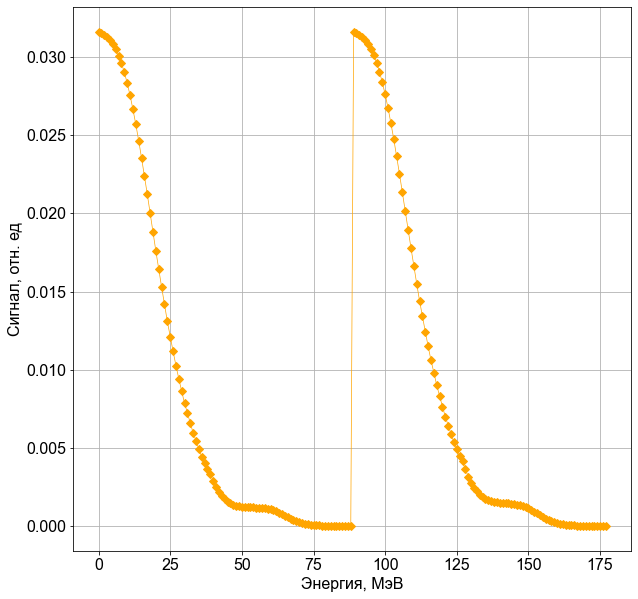

In [309]:
number_of_signals = len(system3)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(signals3)), signals3, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

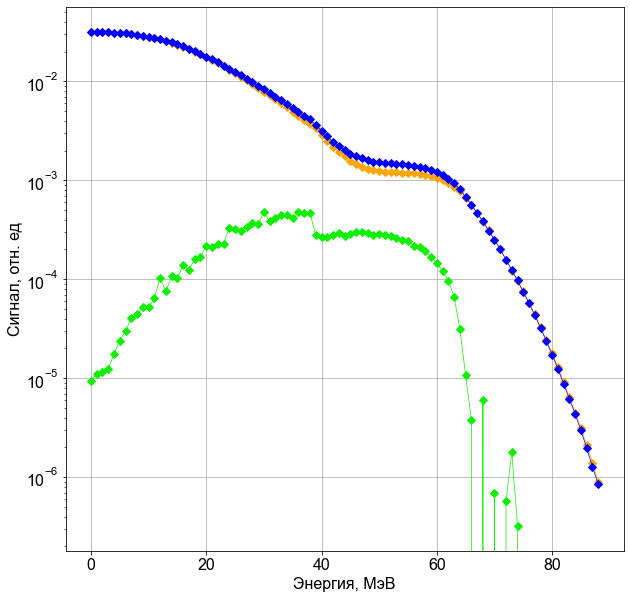

In [310]:
number_of_signals = len(signals1)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(number_of_signals), signals1, ls='-', marker='D', lw='0.7', ms=5, color='orange')
ax.plot(range(number_of_signals), signals2, ls='-', marker='D', lw='0.7', ms=5, color='blue')
ax.plot(range(number_of_signals), signals0, ls='-', marker='D', lw='0.7', ms=5, color='#0ff000')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Восстановление спектра

In [311]:
bound_100_kev = Material(100).k_edge_index()

In [326]:
result = Gold(matrix0, signals0, 0, ENERGY_MESH, new_mesh0, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')

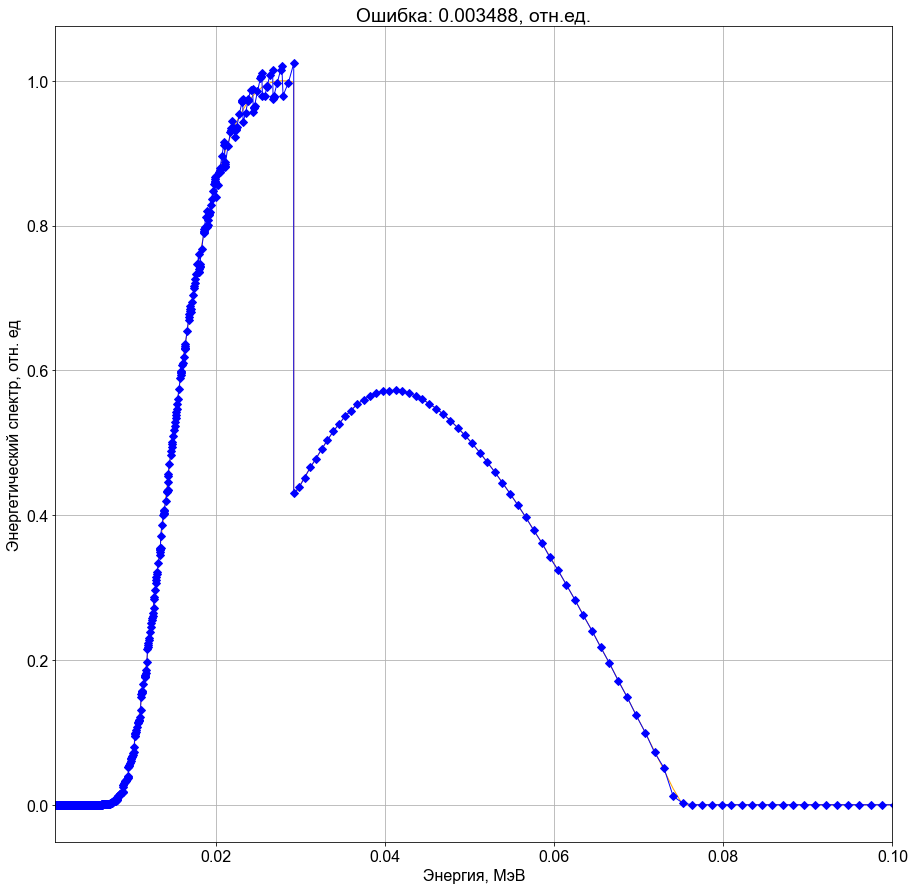

In [327]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', ms=5, color='orange')
ax.plot(new_mesh, result[0], ls='-', lw='1', marker='D', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.set_title(f'Ошибка: {round(result[1], 6)}, отн.ед.')

ax.grid(True)

Зависимость точности восстановления от обусловленности системы

In [262]:
max_level = 0.3

In [319]:
levels = np.linspace(0.3, 0.01, 15)

In [330]:
# CONDS_M0 = np.empty((len(levels)), dtype=object)
# CONDS_M1 = np.empty((len(levels)), dtype=object)
# CONDS_M2 = np.empty((len(levels)), dtype=object)
# CONDS_M3 = np.empty((len(levels)), dtype=object)

# SIGNALS_M1 = np.empty((len(levels)), dtype=object)
# SIGNALS_M2 = np.empty((len(levels)), dtype=object)
# SIGNALS_M3 = np.empty((len(levels)), dtype=object)

# DEVIATIONS_R = np.empty((len(levels)), dtype=object)
# DEVIATIONS = np.empty((len(levels)), dtype=object)

# UNFOLDED_SPECTRUMS0 = np.empty((len(levels)), dtype=object)
# UNFOLDED_SPECTRUMS2 = np.empty((len(levels)), dtype=object)

In [331]:
# start_time = time.time()

# for i, level in enumerate(levels):
#     system0 = np.array([ross_method_transmission_function(num, num+1, level, regime='different') for num in range(first_channel, last_channel)])
#     system1 = np.array([ross_method_transmission_function(num, num+1, level, regime='first') for num in range(first_channel, last_channel)])
#     system2 = np.array([ross_method_transmission_function(num, num+1, level, regime='second') for num in range(first_channel, last_channel)])
#     system3 = np.vstack((system1, system2))
    
#     # создание матрицы задачи
#     matrix0 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system0])
#     matrix1 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system1])
#     matrix2 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system2])
#     matrix3 = np.vstack((matrix1, matrix2))
    
#     signals0 = np.array([simpson_rule(r*brem) for r in system0])
#     signals1 = np.array([simpson_rule(r*brem) for r in system1])
#     signals2 = np.array([simpson_rule(r*brem) for r in system2])
#     signals3 = np.array([simpson_rule(r*brem) for r in system3])
    
#     result0 = Gold(matrix0, signals0, 0, ENERGY_MESH, new_mesh0, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
# #     result1 = Gold(matrix1, signals1, -1, ENERGY_MESH, new_mesh1, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
# #     result2 = Gold(matrix2, signals2, -1, ENERGY_MESH, new_mesh2, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
#     result3 = Gold(matrix3, signals3, 0, ENERGY_MESH, new_mesh3, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
    
#     CONDS_M0[i] = np.linalg.cond(matrix2)
#     CONDS_M3[i] = np.linalg.cond(matrix3)
    
#     SIGNALS_M1[i] = signals1
#     SIGNALS_M2[i] = signals2
    
#     UNFOLDED_SPECTRUMS0 = result2[0]
#     UNFOLDED_SPECTRUMS3 = result3[0]
    
#     DEVIATIONS_R[i] = result0[1]
#     DEVIATIONS[i] = result3[1]
    
#     print(i, f'{round(time.time()-start_time, 5)} секунд')

0 26.4879 секунд
1 52.72205 секунд
2 79.43893 секунд
3 105.77267 секунд
4 132.01774 секунд
5 158.17607 секунд
6 184.71553 секунд
7 211.34208 секунд
8 237.626 секунд
9 263.81776 секунд
10 290.43909 секунд
11 316.7943 секунд
12 343.74167 секунд
13 369.90952 секунд
14 396.11578 секунд
15 422.19975 секунд
16 448.40244 секунд
17 474.62712 секунд
18 500.61656 секунд
19 526.74265 секунд
20 553.19736 секунд
21 579.4316 секунд
22 605.51216 секунд
23 632.24275 секунд
24 658.50683 секунд
25 684.68525 секунд
26 710.75185 секунд
27 736.86333 секунд
28 762.9659 секунд
29 789.02644 секунд


In [332]:
SIGNALS_NORM = [np.linalg.norm(SIGNALS_M2[i]-SIGNALS_M1[i]) for i in range(len(levels))]

Сохранение эксель файлов

In [335]:
from xlsxwriter.workbook import Workbook

workbook = Workbook("спектр7.xlsx")
worksheet = workbook.add_worksheet('Лист1')

worksheet.write_column(5, 4, CONDS_M0)
worksheet.write_column(5, 5, CONDS_M3)
worksheet.write_column(5, 7, DEVIATIONS_R)
worksheet.write_column(5, 8, DEVIATIONS)
worksheet.write_column(5, 9, SIGNALS_NORM)

workbook.close()

Сохранение результатов

In [160]:
# K_EDGE_METHOD_SIGNALS = np.save('СИГНАЛЫ_К_пропускание_08.npy', SIGNALS)